In [1]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
sys.path.append('mask_bracket')
import params

%matplotlib inline 

Using TensorFlow backend.


In [2]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

def show_image(image, title=None):
    channels = image.shape[2] if len(image.shape) == 3 else 1
    if channels == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    oldfigsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (image.shape[1]//100+1,image.shape[0]//100+1)
    plt.autoscale(enable=True, axis='both', tight=False)
    plt.axis('off')
    plt.imshow(image, aspect='equal', interpolation='gaussian', cmap='gray' if channels == 1 else None)
    plt.title(title)
    plt.show()
    plt.rcParams["figure.figsize"] = oldfigsize

Using our trained UNET model to highlight brackets. Wrapped it in highlight_brackets function

In [3]:
def highlight_brackets(image):
  input_size = params.input_size
  model = params.model_factory()
  model.load_weights('mask_bracket/baseline.h5')
  img = params.simplify_image(image)

  orig_height, orig_width = img.shape
  img = cv2.resize(img, (input_size, input_size))
  img = np.array(img, np.float32) / 255
  preds = model.predict(img.reshape(1,input_size,input_size,1))
  preds = np.squeeze(preds, axis=3)
  pred = preds[0]
  pred = cv2.resize(pred, (orig_width, orig_height))
  res = (pred >= 0.5).astype(int)*255
  return res.astype("uint8")

In [4]:
original_image = cv2.imread('sample6.jpg')
image = cv2.imread('sample6.jpg', cv2.IMREAD_GRAYSCALE)

Getting masks for brackets

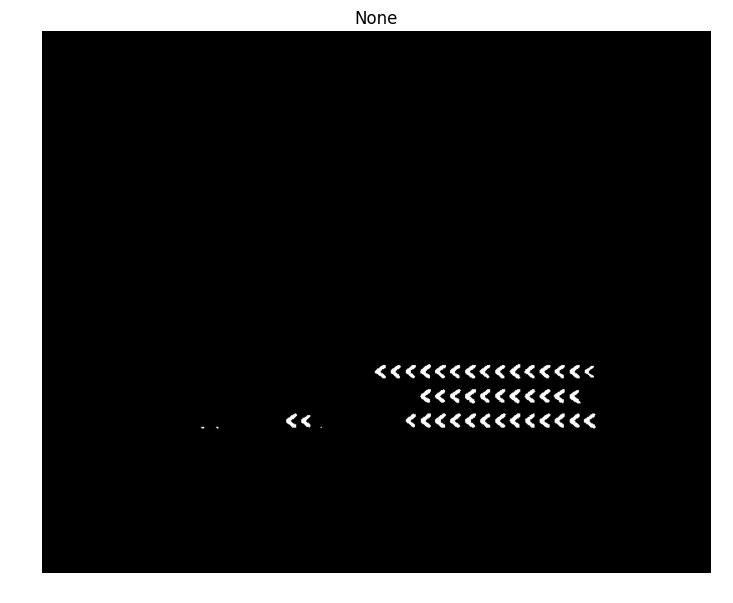

In [5]:
highlighted = highlight_brackets(image)
show_image(highlighted)

Then, it will be easy to find boundaries with cv2.findContours

In [10]:
def get_boundaries(imgray):
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    _, contours, _  = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cords in contours:
         x = [a[0] for a in np.squeeze(cords)]
         y = [a[1] for a in np.squeeze(cords)]
         minx, maxx = np.min(x), np.max(x)
         miny, maxy = np.min(y), np.max(y)
         boxes.append((minx,miny,maxx,maxy))
    return boxes        
            
def draw_boundaries(image, boxes):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    for (minx,miny,maxx,maxy) in boxes:
         rect = Rectangle((minx,miny),maxx-minx,maxy-miny,linewidth=1,edgecolor='g',facecolor='none')
         ax.add_patch(rect)

Let's see the result for this step

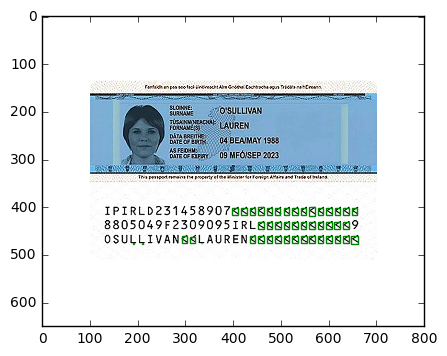

In [11]:
boxes = get_boundaries(highlighted)
draw_boundaries(original_image, boxes)